In [270]:
#%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, BatchNormalization, Flatten
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

In [271]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content.decode('utf-8'))['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'
print(hist.head(5))
hist = hist.drop(['conversionSymbol','conversionType'],axis=1)

             close conversionSymbol conversionType    high     low    open  \
time                                                                         
2015-12-16  453.98                          direct  465.16  437.37  462.65   
2015-12-17  455.53                          direct  458.44  447.29  453.98   
2015-12-18  463.18                          direct  466.12  453.46  455.53   
2015-12-19  461.20                          direct  465.99  452.33  463.18   
2015-12-20  441.78                          direct  462.76  431.10  461.20   

            volumefrom     volumeto  
time                                 
2015-12-16   185221.17  84336145.39  
2015-12-17    64574.94  29344348.08  
2015-12-18    83409.95  38425211.05  
2015-12-19    61309.41  28327900.15  
2015-12-20   121531.64  54316484.95  


In [272]:
hist.head(5)
hist.to_csv('bitcoin2016to2021.csv',index=None)

In [273]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [274]:
train, test = train_test_split(hist, test_size=0.2)

In [275]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

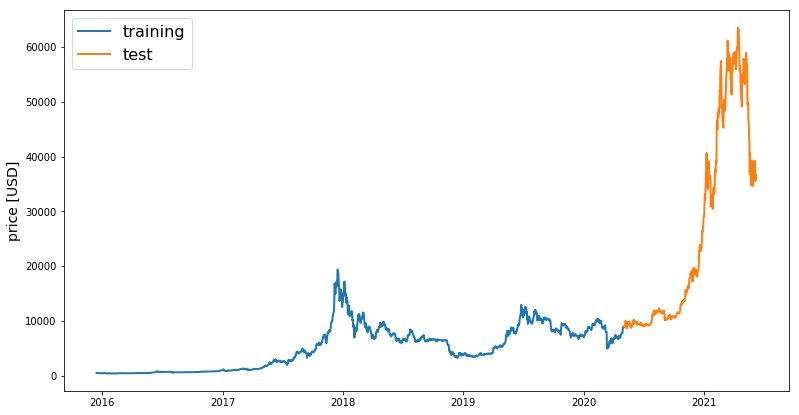

In [276]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [277]:
def normalise_zero_base(df):
    #print(df.iloc[0])
    #return df
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [278]:
def extract_window_data(df, window_len, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [279]:
def prepare_data_new(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = extract_window_data(train_data[target_col][window_len:],int(window_len/2),zero_base)
    y_test = extract_window_data(test_data[target_col][window_len:],int(window_len/2),zero_base)
    #if zero_base:
    #    y_train = y_train / train_data[target_col][:-window_len].values - 1
    #    y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test
def prepare_data(df, target_col, window_len, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    #print(train_data[target_col][:-window_len].values)
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [138]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [309]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [310]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [258]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
1591/1591 [==============================] - 3s 2ms/step - loss: 0.0075
Epoch 2/20
1591/1591 [==============================] - 1s 696us/step - loss: 0.0044
Epoch 3/20
1591/1591 [==============================] - 1s 650us/step - loss: 0.0037
Epoch 4/20
1591/1591 [==============================] - 1s 664us/step - loss: 0.0034
Epoch 5/20
1591/1591 [==============================] - 1s 643us/step - loss: 0.0031
Epoch 6/20
1591/1591 [==============================] - 1s 556us/step - loss: 0.0028
Epoch 7/20
1591/1591 [==============================] - 1s 667us/step - loss: 0.0029
Epoch 8/20
1591/1591 [==============================] - 1s 703us/step - loss: 0.0024
Epoch 9/20
1591/1591 [==============================] - 1s 717us/step - loss: 0.0025
Epoch 10/20
1591/1591 [==============================] - 1s 702us/step - loss: 0.0024
Epoch 11/20
1591/1591 [==============================] - 1s 683us/step - loss: 0.0025
Epoch 12/20
1591/1591 [==============================] - 1s 721us

In [259]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_squared_error(preds, y_test)
#mean_absolute_error(preds, y_test)

0.0018550347196308044

167.54794791592548
888.4377179719455


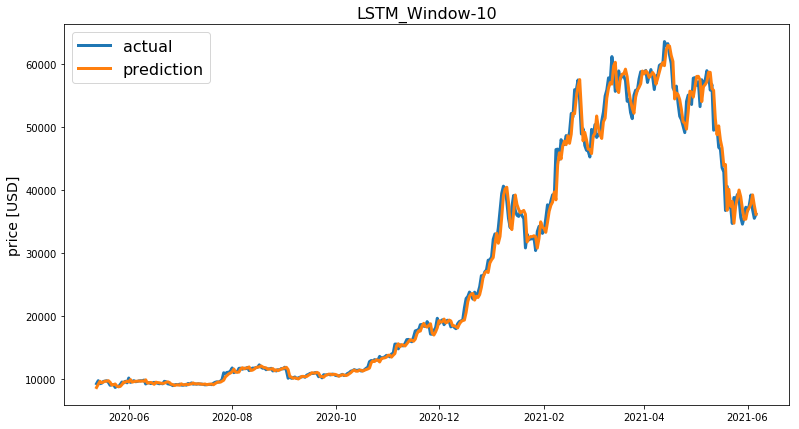

In [260]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
targets_train = train[target_col][window_len:]
preds_train = model.predict(X_train).squeeze()
preds_train = train[target_col].values[:-window_len] * (preds_train + 1)
print(mean_absolute_error(preds_train, targets_train))
print(mean_absolute_error(preds, targets))

line_plot(targets, preds, 'actual', 'prediction', lw=3,title='LSTM_Window-10')

In [98]:
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [261]:
def build_cnn_model(input_data, output_size,
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(Conv1D(activation='relu', input_shape=(input_data.shape[1], input_data.shape[2]), filters=64, kernel_size=2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [262]:
cnn_model = build_cnn_model(
    X_train, output_size=1, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = cnn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
1591/1591 [==============================] - 2s 1ms/step - loss: 0.0112
Epoch 2/20
1591/1591 [==============================] - 0s 123us/step - loss: 0.0064
Epoch 3/20
1591/1591 [==============================] - 0s 121us/step - loss: 0.0056
Epoch 4/20
1591/1591 [==============================] - 0s 118us/step - loss: 0.0049
Epoch 5/20
1591/1591 [==============================] - 0s 117us/step - loss: 0.0083
Epoch 6/20
1591/1591 [==============================] - 0s 117us/step - loss: 0.0090
Epoch 7/20
1591/1591 [==============================] - 0s 121us/step - loss: 0.0044
Epoch 8/20
1591/1591 [==============================] - 0s 111us/step - loss: 0.0039
Epoch 9/20
1591/1591 [==============================] - 0s 107us/step - loss: 0.0038
Epoch 10/20
1591/1591 [==============================] - 0s 106us/step - loss: 0.0036
Epoch 11/20
1591/1591 [==============================] - 0s 111us/step - loss: 0.0034
Epoch 12/20
1591/1591 [==============================] - 0s 106us

[ 0.0460583   0.10263183  0.03122346  0.02555172 -0.03293723]
[-0.03708048  0.0021811  -0.00697498  0.10081277  0.00593078]
0.0043908352111550015
time
2020-05-13    9317.44
2020-05-14    9793.19
2020-05-15    9311.69
2020-05-16    9387.08
2020-05-17    9670.56
Name: close, dtype: float64
time
2020-05-13     8576.907237
2020-05-14     8901.021351
2020-05-15     8966.767538
2020-05-16    10075.959655
2020-05-17    10059.237398
dtype: float64
1425.204686971512
217.5835558252201


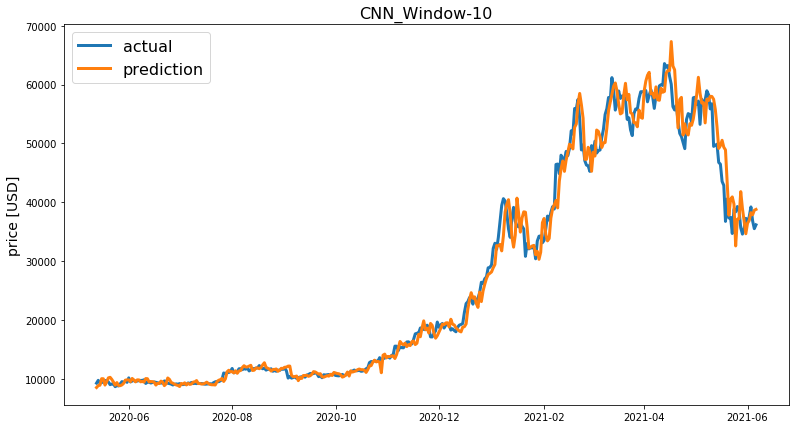

In [263]:
targets = test[target_col][window_len:]
preds = cnn_model.predict(X_test).squeeze()
targets_train = train[target_col][window_len:]
preds_train = cnn_model.predict(X_train).squeeze()
preds_train = train[target_col].values[:-window_len] * (preds_train + 1)
print( y_test[:5])
print(preds[:5])
print(mean_squared_error(preds, y_test))
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
print(targets[:5])
print(preds[:5])
print(mean_absolute_error(preds, targets))
print(mean_absolute_error(preds_train, targets_train))
line_plot(targets, preds, 'actual', 'prediction', lw=3,title='CNN_Window-10')

In [334]:
gru_neurons = 100
epochs = 30
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
def build_gru_model(input_data, output_size, neurons=100,
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    #model.add(Activation('tanh'))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [335]:
gru_model = build_lstm_model(
    X_train, output_size=1, neurons=gru_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = gru_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/30
1596/1596 [==============================] - 7s 4ms/step - loss: 0.0069
Epoch 2/30
1596/1596 [==============================] - 1s 410us/step - loss: 0.0036
Epoch 3/30
1596/1596 [==============================] - 1s 449us/step - loss: 0.0030
Epoch 4/30
1596/1596 [==============================] - 1s 441us/step - loss: 0.0027
Epoch 5/30
1596/1596 [==============================] - 1s 454us/step - loss: 0.0025
Epoch 6/30
1596/1596 [==============================] - 1s 462us/step - loss: 0.0024
Epoch 7/30
1596/1596 [==============================] - 1s 452us/step - loss: 0.0022
Epoch 8/30
1596/1596 [==============================] - 1s 471us/step - loss: 0.0021
Epoch 9/30
1596/1596 [==============================] - 1s 459us/step - loss: 0.0021
Epoch 10/30
1596/1596 [==============================] - 1s 462us/step - loss: 0.0020
Epoch 11/30
1596/1596 [==============================] - 1s 467us/step - loss: 0.0021
Epoch 12/30
1596/1596 [==============================] - 1s 485us

(395,)
832.7132684275784
160.98039288590616


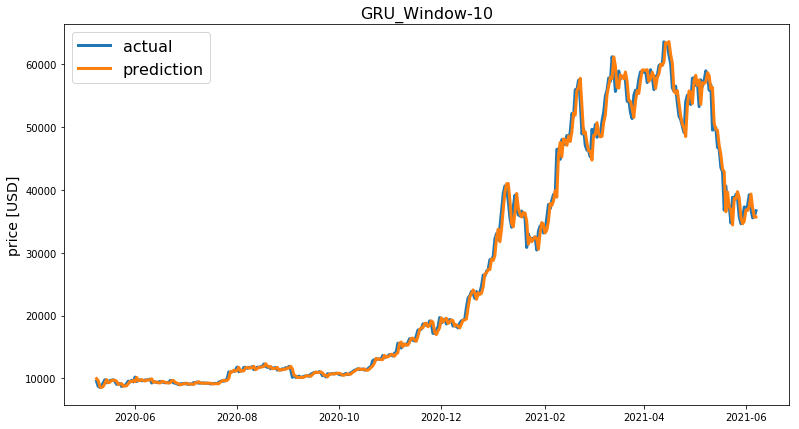

In [336]:
targets = test[target_col][window_len:]
preds = gru_model.predict(X_test).squeeze()
mean_squared_error(preds, y_test)
print(preds.shape)
targets_train = train[target_col][window_len:]
preds_train = gru_model.predict(X_train).squeeze()
preds = test[target_col].values[:-window_len] * (preds + 1)
preds_train = train[target_col].values[:-window_len] * (preds_train + 1)
preds = pd.Series(index=targets.index, data=preds)
print(mean_absolute_error(preds, targets))
print(mean_absolute_error(preds_train, targets_train))
line_plot(targets, preds, 'actual', 'prediction', lw=3, title='GRU_Window-10')

In [331]:
def build_mul_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]),return_sequences=True))
    model.add(Dropout(dropout))
    #odel.add(BatchNormalization())
    
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]),return_sequences=True))
    model.add(Dropout(dropout))
    #del.add(BatchNormalization())
    
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    #odel.add(BatchNormalization())
    #odel.add(Dense(units=10))
    #odel.add(Activation(activ_func))
    #odel.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [332]:
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
model_mul_lstm = build_mul_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model_mul_lstm.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
1596/1596 [==============================] - 8s 5ms/step - loss: 0.0072
Epoch 2/20
1596/1596 [==============================] - 1s 921us/step - loss: 0.0047
Epoch 3/20
1596/1596 [==============================] - 1s 919us/step - loss: 0.0036
Epoch 4/20
1596/1596 [==============================] - 2s 955us/step - loss: 0.0030
Epoch 5/20
1596/1596 [==============================] - 1s 904us/step - loss: 0.0026
Epoch 6/20
1596/1596 [==============================] - 1s 939us/step - loss: 0.0024
Epoch 7/20
1596/1596 [==============================] - 2s 942us/step - loss: 0.0022
Epoch 8/20
1596/1596 [==============================] - 1s 928us/step - loss: 0.0022
Epoch 9/20
1596/1596 [==============================] - 1s 934us/step - loss: 0.0021
Epoch 10/20
1596/1596 [==============================] - 1s 925us/step - loss: 0.0021
Epoch 11/20
1596/1596 [==============================] - 2s 942us/step - loss: 0.0021
Epoch 12/20
1596/1596 [==============================] - 1s 931us

time
2020-05-09    9541.13
2020-05-10    8735.05
2020-05-11    8568.88
2020-05-12    8821.18
2020-05-13    9317.44
Name: close, dtype: float64
time
2020-05-09    9848.986185
2020-05-10    9572.518340
2020-05-11    8632.931543
2020-05-12    8771.865953
2020-05-13    8956.261936
dtype: float64
886.3525287372191
163.76008323183672


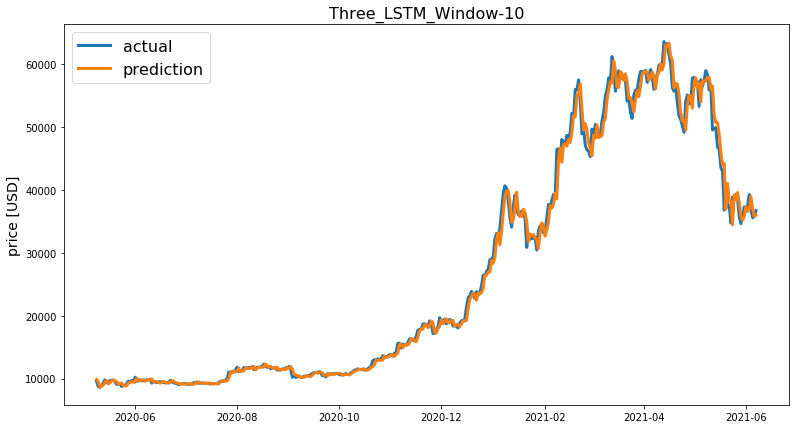

In [333]:
targets = test[target_col][window_len:]
#print(X_test.shape)
preds = model_mul_lstm.predict(X_test).squeeze()
targets_train = train[target_col][window_len:]
preds_train = model_mul_lstm.predict(X_train).squeeze()
#print(targets[1])
#print(preds[1])
preds = test[target_col].values[:-window_len] * (preds + 1)
preds_train = train[target_col].values[:-window_len] * (preds_train + 1)
preds = pd.Series(index=targets.index, data=preds)
print(targets[:5])
print(preds[:5])
print(mean_absolute_error(preds, targets))
print(mean_absolute_error(preds_train, targets_train))
line_plot(targets, preds, 'actual', 'prediction', lw=3,title='Three_LSTM_Window-10')

In [311]:
def build_optimized_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons,activation='tanh', input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(LeakyReLU())

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [312]:
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
model_optimized_lstm = build_optimized_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model_optimized_lstm.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
1596/1596 [==============================] - 4s 3ms/step - loss: 0.0058
Epoch 2/20
1596/1596 [==============================] - 1s 418us/step - loss: 0.0041
Epoch 3/20
1596/1596 [==============================] - 1s 439us/step - loss: 0.0036
Epoch 4/20
1596/1596 [==============================] - 1s 417us/step - loss: 0.0033
Epoch 5/20
1596/1596 [==============================] - 1s 455us/step - loss: 0.0031
Epoch 6/20
1596/1596 [==============================] - 1s 462us/step - loss: 0.0032
Epoch 7/20
1596/1596 [==============================] - 1s 452us/step - loss: 0.0029
Epoch 8/20
1596/1596 [==============================] - 1s 448us/step - loss: 0.0028
Epoch 9/20
1596/1596 [==============================] - 1s 380us/step - loss: 0.0027
Epoch 10/20
1596/1596 [==============================] - 1s 396us/step - loss: 0.0027
Epoch 11/20
1596/1596 [==============================] - 1s 443us/step - loss: 0.0025
Epoch 12/20
1596/1596 [==============================] - 1s 442us

time
2020-05-09    9541.13
2020-05-10    8735.05
2020-05-11    8568.88
2020-05-12    8821.18
2020-05-13    9317.44
Name: close, dtype: float64
time
2020-05-09    10073.387233
2020-05-10     9688.383122
2020-05-11     8888.251088
2020-05-12     9176.929131
2020-05-13     9068.640940
dtype: float64
978.992445847798
183.7189407155807


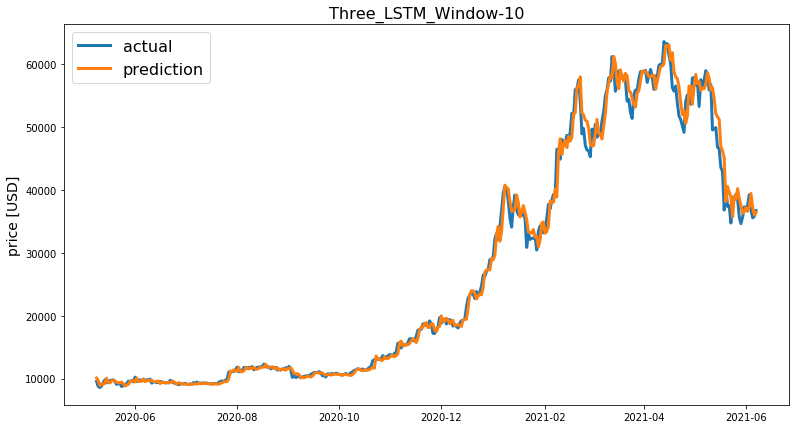

In [314]:
targets = test[target_col][window_len:]
#print(X_test.shape)
preds = model_optimized_lstm.predict(X_test).squeeze()
targets_train = train[target_col][window_len:]
preds_train = model_optimized_lstm.predict(X_train).squeeze()
#print(targets[1])
#print(preds[1])
preds = test[target_col].values[:-window_len] * (preds + 1)
preds_train = train[target_col].values[:-window_len] * (preds_train + 1)
preds = pd.Series(index=targets.index, data=preds)
print(targets[:5])
print(preds[:5])
print(mean_absolute_error(preds, targets))
print(mean_absolute_error(preds_train, targets_train))
line_plot(targets, preds, 'actual', 'prediction', lw=3,title='Three_LSTM_Window-10')

In [330]:
#test the preformance on DOGE coin
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=DOGE&tsym=USD&limit=2000')
hist_doge = pd.DataFrame(json.loads(res.content.decode('utf-8'))['Data'])
hist_doge = hist_doge.set_index('time')
hist_doge.index = pd.to_datetime(hist_doge.index, unit='s')
target_col = 'close'
print(hist_doge.head(5))
hist_doge = hist_doge.drop(['conversionSymbol','conversionType'],axis=1)

               close conversionSymbol conversionType      high       low  \
time                                                                       
2015-12-16  0.000139                          direct  0.000139  0.000139   
2015-12-17  0.000182                          direct  0.000182  0.000162   
2015-12-18  0.000175                          direct  0.000182  0.000162   
2015-12-19  0.000134              BTC       multiply  0.000143  0.000134   
2015-12-20  0.000164                          direct  0.000170  0.000164   

                open    volumefrom      volumeto  
time                                              
2015-12-16  0.000140  8.790000e+02      0.122200  
2015-12-17  0.000164  4.577483e+04      6.344000  
2015-12-18  0.000182  1.700000e+01      0.002499  
2015-12-19  0.000139  1.770707e+08  23682.850000  
2015-12-20  0.000165  2.791000e+01      0.004046  


In [337]:
train_doge, test_doge = train_test_split(hist_doge, test_size=0.2)
train_doge, test_doge, X_train_doge, X_test_doge, y_train_doge, y_test_doge = prepare_data(
    hist_doge, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

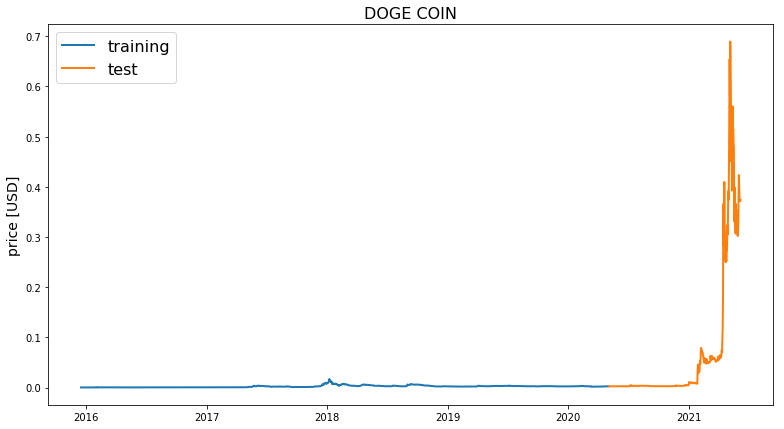

In [338]:
line_plot(train_doge[target_col], test_doge[target_col], 'training', 'test', title='DOGE COIN')

time
2020-05-09    0.002570
2020-05-10    0.002520
2020-05-11    0.002438
2020-05-12    0.002506
2020-05-13    0.002515
Name: close, dtype: float64
time
2020-05-09    0.002616
2020-05-10    0.002562
2020-05-11    0.002404
2020-05-12    0.002467
2020-05-13    0.002529
dtype: float64
0.007972219751226146
0.00011521598783658636


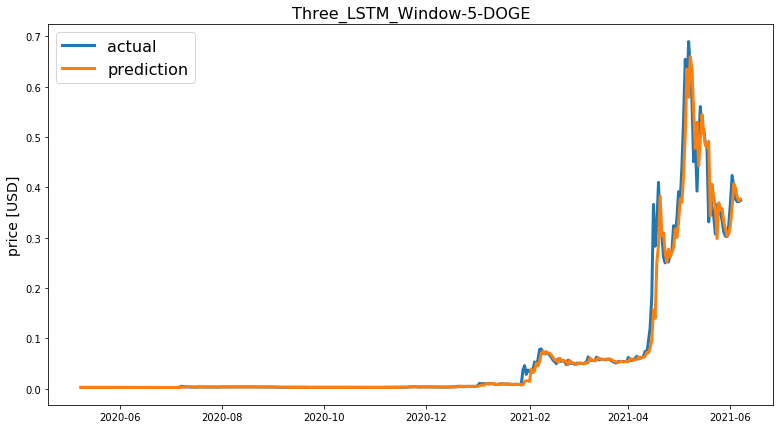

In [339]:
targets = test_doge[target_col][window_len:]
#print(X_test.shape)
preds = model_mul_lstm.predict(X_test_doge).squeeze()
targets_train = train_doge[target_col][window_len:]
preds_train = model_mul_lstm.predict(X_train_doge).squeeze()
#print(targets[1])
#print(preds[1])
preds = test_doge[target_col].values[:-window_len] * (preds + 1)
preds_train = train_doge[target_col].values[:-window_len] * (preds_train + 1)
preds = pd.Series(index=targets.index, data=preds)
print(targets[:5])
print(preds[:5])
print(mean_absolute_error(preds, targets))
print(mean_absolute_error(preds_train, targets_train))
line_plot(targets, preds, 'actual', 'prediction', lw=3,title='Three_LSTM_Window-5-DOGE')

In [340]:
hist_doge.to_csv('dogecoin2016to2021.csv',index=None)